# C-Convex Duality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import style
style.use('ggplot')
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers


print("Necessary Packages imported")

Necessary Packages imported


Define the convex envelope by using the convex biconjugate
$$
f^{**}(x)  = \sup_{m \in \mathbb{R}} \left\{ m \cdot x-\sup_{y \in \mathbb{R}} \left\{ y \cdot m -f(y)\right\} \right\}
$$


Note that the implementation of the convex envelope is batchwise to allow a more efficient computation

In [2]:
def convex_biconjugate(f, x_vals, min_range=-1,max_range = 1, number_of_steps = 100,batch1 = False,batch2 = False):
    
    # Range of possible slopes
    m_vals = np.linspace(min_range,max_range,number_of_steps)
    
    if batch1: # Computation on a batch of S_1 - values
        def f_star(y):
            """
            The conjugate of f.
            """
            return tf.reduce_max(tf.expand_dims(y*x_vals,0) -tf.expand_dims(f(x_vals),2),1)   

        def f_bistar(x):
            """
            The conjugate of f.
            """
            return tf.reduce_max(tf.expand_dims(m_vals*x,0) - tf.expand_dims(f_star(m_vals),1),2) 
        return f_bistar  
    
    elif batch2: # Computation on a batch of S_1 and x_2 values
        def f_star(y):
            """
            The conjugate of f.
            """
            return tf.reduce_max(tf.expand_dims(tf.expand_dims(y*x_vals,0),0)-tf.expand_dims(f(x_vals),3),2) 

        def f_bistar(x):
            """
            The conjugate of f.
            """
            return tf.reduce_max(tf.expand_dims(m_vals*x,0) - f_star(m_vals),2) 
        return f_bistar      
    # And if the computation is not on a batch of S1 values:
    else:
        def f_star(y):
            """
            The conjugate of f.
            """
            return tf.reduce_max(y*x_vals-f(x_vals),0) #m_vals*x_vals: (x_vals_dim,M_Vals_dim)   f(x_vals): (x_vals_dim,1)


        def f_bistar(x):
            """
            The conjugate of fstar.
            """
            return tf.reduce_max(m_vals*x - f_star(m_vals),1) # (B,M_Vals_dim) - (1,M_Vals_dim)
        return f_bistar

# Example: sin(x)

If computed on a small range of x values

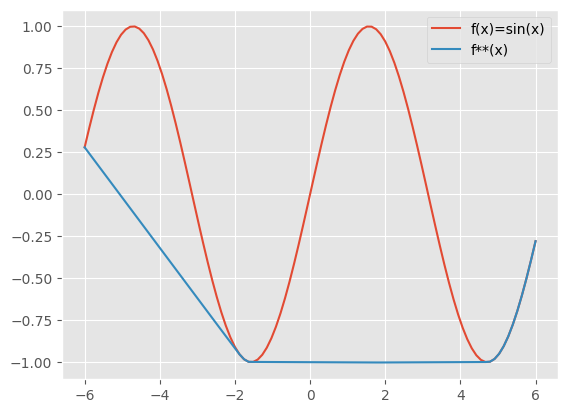

In [3]:
min_val,max_val = -6,6
n_steps = 100

x_vals = tf.reshape(tf.linspace(min_val,max_val,n_steps),(n_steps,1))
plt.plot(x_vals,tf.math.sin(x_vals),label = "f(x)=sin(x)")
plt.plot(x_vals,convex_biconjugate(tf.math.sin,x_vals, number_of_steps = 1000)(x_vals),label = "f**(x)")
plt.legend()
plt.show()

If computed on a larger range of x values

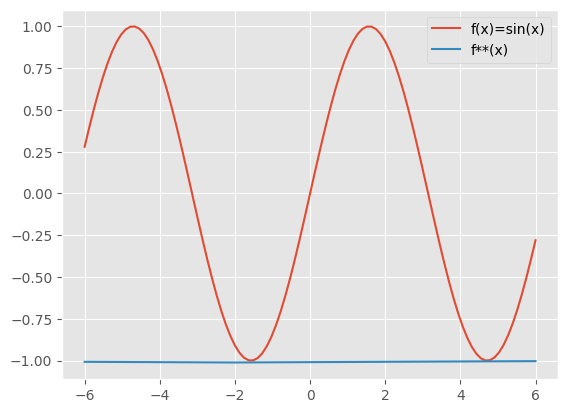

In [4]:
min_val,max_val = -15,15
n_steps = 100

x_vals_large = tf.reshape(tf.linspace(min_val,max_val,n_steps),(n_steps,1))
plt.plot(x_vals,tf.math.sin(x_vals),label = "f(x)=sin(x)")
plt.plot(x_vals,convex_biconjugate(tf.math.sin,x_vals_large, number_of_steps = 1000)(x_vals),label = "f**(x)")
plt.legend()
plt.show()

Define the function for the optimization (for 3 marginals)

In [5]:
def MOT(payoff,
        marginal1,
        marginal2,
        marginal3,
        xval_distribution,
        max_iter=100,
        batch_size=32,
        depth=2, 
        nr_neurons=64,
        l_r=0.001,
        upper_bound=False):
    """
    payoff: 3 dimensional payoff function, ideally a tf. function
    marginal1, marginal2, marginal3: Generators of the marginal distirbutions, Shape: (Batchsize,1)
    xval_distribution: Generator for the x values on which the convex envelope should be evaluated, Shape: (N,1) for some N
    max_iter: Number of Iterations
    Batch_size: Batch_size of x_1,x_2,x_3 values
    depth: Depth (Number of Hidden Layers) of the neural network
    nr_neuronts: Number of neurons in each layer of the neural network
    l_r: The learning rate of the Adam optimizer
    upper_bound: Whether an Upper Price Bound should be computed
    """
    if upper_bound == True:
        Minmax = -1
    else:
        Minmax = 1

    def build_model():        
        #t1
        x = keras.Input(shape=(1,),name="x")
        # Create the NN       
        u_2 = layers.Dense(nr_neurons,activation="relu")(x)
        u_3 = layers.Dense(nr_neurons,activation="relu")(x)
        # Create deep layers
        for i in range(depth):
            u_2 = layers.Dense(nr_neurons,activation="relu")(u_2)
            u_3 = layers.Dense(nr_neurons,activation="relu")(u_3)
        # Output Layers
        u_2 = layers.Dense(1)(u_2)
        u_3 = layers.Dense(1)(u_3)
        model = keras.Model(inputs=[x],outputs=[u_2,u_3])
        return model

    # Loss function
    def loss(model,x_1,x_2,x_3):          
        # Compute c_3, c_2 and c_1
        # Sample Values on which the convex envelope will be evaluated
        x_vals1 = tf.sort(tf.concat([next(xval_distribution(batch_size))],0),0)
        x_vals2 = tf.sort(tf.concat([next(xval_distribution(batch_size))],0),0)    

        def c_3(x,y,z):
          costs = Minmax*payoff(tf.expand_dims(x,1),tf.expand_dims(y,0),tf.transpose(tf.expand_dims(z,1)))
          u2 = tf.expand_dims(model({"x": tf.reshape(y,-1)})[0],0)
          u3 = tf.transpose(tf.expand_dims(model({"x": tf.reshape(z,-1)})[1],1))
          return costs - (u2+u3) # (32,10,20)

        def c_2(x,y):
          return_val = convex_biconjugate(lambda z: c_3(x,y,z), x_vals2,batch2 = True)(y)
          return return_val #(32,10)

        c_1 = convex_biconjugate(lambda y : c_2(x_1,y), x_vals1,batch1 = True)(x_1)

        u_1 = tf.reshape(tf.linalg.tensor_diag_part(c_1),(batch_size,1))
        u_2 = model({"x": x_2})[0]
        u_3 = model({"x": x_3})[1]

        to_maximize = u_1+u_2+u_3
        l = tf.reduce_mean(-to_maximize)
        return l

    # Define Gradient    
    def grad(model,x_1,x_2,x_3):
        with tf.GradientTape() as tape:
            loss_value = loss(model,x_1,x_2,x_3)
        return loss_value, tape.gradient(loss_value,model.trainable_variables)

      # Define an optimizer and initialize the model
    optimizer = tf.keras.optimizers.Adam(learning_rate = l_r)
    model = build_model()
    losses = []

    # Training Loop
    for epoch in range(int(max_iter)):
        x_1 = next(marginal1(batch_size))
        x_2 = next(marginal2(batch_size)) 
        x_3 = next(marginal3(batch_size)) 

        # Then train the remaining functions
        loss_value, grads = grad(model,x_1,x_2,x_3)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(-Minmax*loss_value.numpy())

        if epoch % 500 == 0 and epoch > 0:
                print("Iteration:{}, Avg. Loss: {}".format((epoch),np.mean(losses[-(round(epoch*0.05)):])))

    print("Iteration result: {}".format(np.mean(losses[-(round(max_iter*0.05)):])))
    return model

# Testing and Evaluation 


Define Marginals and Payoff

Marginals follow a lognormal distribution, i.e.,

$S_i = \exp(\sigma \sqrt{t} \cdot X - \sigma^2 \cdot \frac{t}{2})$ where $X \sim \mathcal{N}(0,1)$

with $\sigma = 0.25$, $t_1 =1$, $t_2 = 2$, $t_3 = 3$.

The payoff is:

$c(S_1,S_2,S_3) = \left(S_3-\frac{1}{2}(S_2+S_1)\right)^+$.

The same Setting was considered in :


Eckstein, S. and Kupper, M., 2021. Martingale transport with homogeneous stock movements. Quantitative Finance, 21(2), pp.271-280.


Therein the mentioned result is 
$$
\inf_{Q \in \mathcal{M}(\mu_1,\mu_2,\mu_3)} \mathbb{E}_Q[c] \approx 0.059.
$$

$$
\sup_{Q \in \mathcal{M}(\mu_1,\mu_2,\mu_3)} \mathbb{E}_Q[c] \approx 0.139.
$$

In [6]:
def mu_1(batch_size):
  while True:
    t = 1
    sigma = 0.25
    x = tf.random.normal(shape = [int(batch_size),1], dtype=tf.dtypes.float32)
    yield tf.math.exp(sigma*np.sqrt(t)*x-(sigma**2)*t*0.5)

            
def mu_2(batch_size):
  while True:
    t = 2
    sigma = 0.25
    x = tf.random.normal(shape = [int(batch_size),1], dtype=tf.dtypes.float32)
    yield tf.math.exp(sigma*np.sqrt(t)*x-(sigma**2)*t*0.5) 

        
def mu_3(batch_size):
  while True:
    t = 3
    sigma = 0.25
    x = tf.random.normal(shape = [int(batch_size),1], dtype=tf.dtypes.float32)
    yield tf.math.exp(sigma*np.sqrt(t)*x-(sigma**2)*t*0.5)

def xval_distribution(batch_size):
  while True:
    a = tf.random.uniform(shape = [1],minval = -0.2, maxval = 0)
    b = tf.random.uniform(shape = [1],minval = 2.4, maxval = 2.6)
    x_vals = tf.linspace(a,b,200)
    yield tf.reshape(x_vals,(200,1))

def payoff(x,y,z):
    return tf.nn.relu(z-0.5*(x+y)) 


## Computation of the Lower Bound




In [7]:
batch_size = 32

# Compute the optimal hedge
u = MOT(payoff,
        mu_1,
        mu_2,
        mu_3,
        xval_distribution,
        max_iter =10000,
        batch_size =batch_size,
        depth = 4,
        nr_neurons = 256,
        l_r=0.0001,
        upper_bound = False)

Iteration:500, Avg. Loss: 0.0382650700956583
Iteration:1000, Avg. Loss: 0.04304639869369566
Iteration:1500, Avg. Loss: 0.048535594635953506
Iteration:2000, Avg. Loss: 0.045816501677036284
Iteration:2500, Avg. Loss: 0.052261941954493525
Iteration:3000, Avg. Loss: 0.052849948595588406
Iteration:3500, Avg. Loss: 0.052981802632233926
Iteration:4000, Avg. Loss: 0.054204497423488644
Iteration:4500, Avg. Loss: 0.05177087180730369
Iteration:5000, Avg. Loss: 0.0514916966650635
Iteration:5500, Avg. Loss: 0.05030476534400474
Iteration:6000, Avg. Loss: 0.05166676968258495
Iteration:6500, Avg. Loss: 0.05407229070480053
Iteration:7000, Avg. Loss: 0.0526431914206062
Iteration:7500, Avg. Loss: 0.054853427216410636
Iteration:8000, Avg. Loss: 0.05426660091732629
Iteration:8500, Avg. Loss: 0.0547983434686766
Iteration:9000, Avg. Loss: 0.054460848283229606
Iteration:9500, Avg. Loss: 0.05248059670293802
Iteration result: 0.05302773337438703


## Computation of the Upper Bound



In [8]:
batch_size = 32

# Compute the optimal hedge
u = MOT(payoff,
        mu_1,
        mu_2,
        mu_3,
        xval_distribution,
        max_iter =10000,
        batch_size =batch_size,
        depth = 4,
        nr_neurons = 256,
        l_r=0.0001,
        upper_bound = True)

Iteration:500, Avg. Loss: 0.15698029831051827
Iteration:1000, Avg. Loss: 0.14292609423398972
Iteration:1500, Avg. Loss: 0.16449941356976827
Iteration:2000, Avg. Loss: 0.14746960239484908
Iteration:2500, Avg. Loss: 0.14548938837647438
Iteration:3000, Avg. Loss: 0.15252697450419267
Iteration:3500, Avg. Loss: 0.1469466488276209
Iteration:4000, Avg. Loss: 0.14532621976919471
Iteration:4500, Avg. Loss: 0.1405782565722863
Iteration:5000, Avg. Loss: 0.14854188088327647
Iteration:5500, Avg. Loss: 0.1511070150441744
Iteration:6000, Avg. Loss: 0.1361330166645348
Iteration:6500, Avg. Loss: 0.14543253489125232
Iteration:7000, Avg. Loss: 0.14742168746356454
Iteration:7500, Avg. Loss: 0.14161323929329714
Iteration:8000, Avg. Loss: 0.1373368078796193
Iteration:8500, Avg. Loss: 0.14470747574725573
Iteration:9000, Avg. Loss: 0.13773347503195207
Iteration:9500, Avg. Loss: 0.13987374276314912
Iteration result: 0.1423664629124105
